# Purpose

### Goal: create deterministic, leakage-safe features from the clean data produced in 01.

### Inputs: Pclass, Age, SibSp, Parch, Fare, Sex, Embarked (+ raw IDs to drop later).

### Outputs: features such as FamilySize.

## Imports

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Setup & load clean data

In [2]:
CLEAN_DIR = "../data/clean"
#os.makedirs(ENGINEERED_DIR, exist_ok=True)

# pick the latest clean file produced by 01 (or set an exact name)
clean_files = sorted([f for f in os.listdir(CLEAN_DIR) if f.startswith("train_clean_") and f.endswith(".csv")])
assert clean_files, "No cleaned file found. Run 01_data_preparation first."
train_clean_csv = os.path.join(CLEAN_DIR, clean_files[-1])
df = pd.read_csv(train_clean_csv)

print("Loaded:", train_clean_csv, "| shape:", df.shape)
df.head(3)

Loaded: ../data/clean\train_clean_20251019-211325.csv | shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Core feature engineering functions

In [3]:
# Columns to drop later (IDs / high-cardinality)
DROP_LATER = ["PassengerId", "Name", "Ticket", "Cabin"]

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Deterministic, leakage-safe feature engineering.
    Only uses raw predictors; NEVER touches the target.
    """
    df = df.copy()

    # Guards: what you need to compute features
    needed = {"SibSp", "Parch"}
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns for engineering: {missing}")

    # FamilySize
    df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1

    return df

def apply_drop(df: pd.DataFrame, drop_cols=DROP_LATER) -> pd.DataFrame:
    return df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

## Apply engineering & preview

In [4]:
df_eng = engineer_features(df)

preview_cols = [c for c in ["SibSp","Parch","FamilySize"] if c in df_eng.columns]
df_eng[preview_cols].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


## Light validations

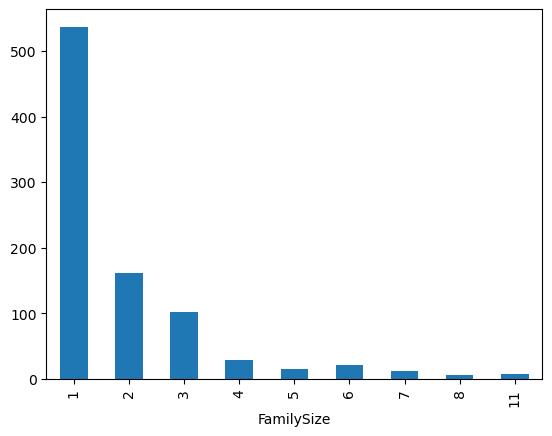

In [5]:
# FamilySize is always >= 1
assert (df_eng["FamilySize"] >= 1).all(), "FamilySize should be >= 1"

# Sanity plots for quick visuals:
df_eng["FamilySize"].value_counts().sort_index().plot(kind="bar");

## Package as a reusable transformer

In [6]:
from sklearn.preprocessing import FunctionTransformer

def _engineer_and_drop(X: pd.DataFrame) -> pd.DataFrame:
    X = engineer_features(pd.DataFrame(X).copy())
    X = apply_drop(X, DROP_LATER)
    return X

engineer_ft = FunctionTransformer(_engineer_and_drop, validate=False, feature_names_out="one-to-one")


## Tiny unit test (guards against regressions)

In [7]:
mini = pd.DataFrame({
    "SibSp":[0,1,2],
    "Parch":[0,1,0],
    "Name":["John Doe Mr.","Jane Doe Mrs.","Kid Doe Master."],
    "Pclass":[3,1,2],
    "Sex":["male","female","male"],
    "Fare":[7.25,71.2833,7.925],
    "Embarked":["S","C","S"],
})
chk = apply_drop(engineer_features(mini), DROP_LATER)
assert list(chk["FamilySize"]) == [1,3,3], chk["FamilySize"].tolist()
print("Unit test OK ✅")

Unit test OK ✅


## Export for notebook 03

In [8]:
# Save the engineering logic in a lightweight module next to notebooks
MODULE_DIR = "src"
os.makedirs(MODULE_DIR, exist_ok=True)

engineer_py = os.path.join(MODULE_DIR, "engineering.py")
with open(engineer_py, "w", encoding="utf-8") as f:
    f.write('''\
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

DROP_LATER = ["PassengerId", "Name", "Ticket", "Cabin"]

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "SibSp" in df and "Parch" in df:
        df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
    return df


class EngineerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=None):
        # IMPORTANT: do not modify params here (clone-safe)
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = engineer_features(pd.DataFrame(X).copy())
        drop_cols = self.drop_cols if self.drop_cols is not None else []
        X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")
        return X

    def get_feature_names_out(self, input_features=None):
        return np.asarray(input_features) if input_features is not None else None
''')
print(f"✅ Exported: {engineer_py}")

✅ Exported: src\engineering.py


### PCA snapshot (post-engineering)

We project the engineered feature space to 2 principal components to visualize the main sources of variance and see whether classes separate in a low-dimensional view.

This is diagnostic only (does not change training). Steps:

1. apply engineer_features,

2. impute/scale numeric + OHE categorical (same spirit as training),

3. run PCA,

4. plot and show explained variance.

Explained variance: PC1=0.377  PC2=0.251  (Total=0.628)


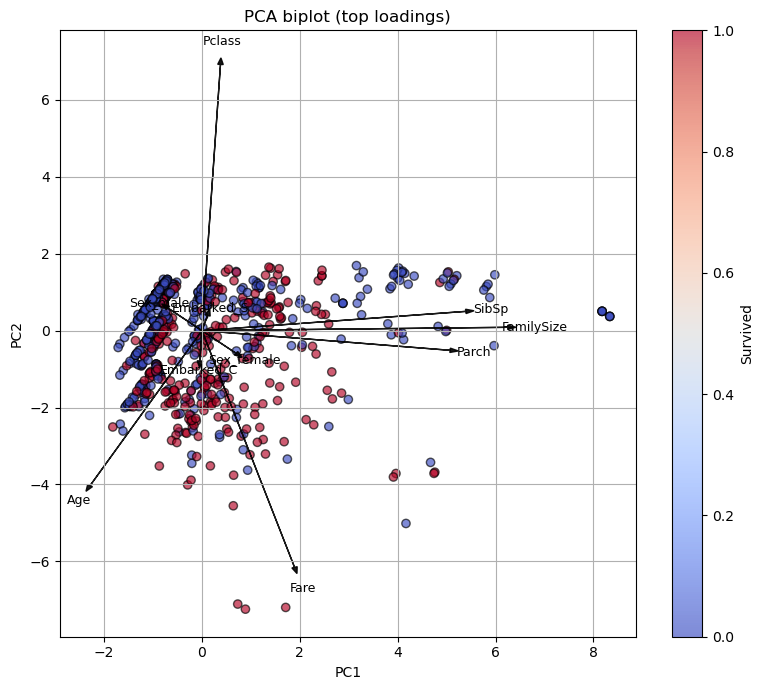


Top loadings — PC1


,feature,loading
0,FamilySize,0.610541
1,SibSp,0.528983
2,Parch,0.498414
3,Age,-0.225442
4,Fare,0.184749
5,Sex_male,-0.078461
6,Sex_female,0.078461
7,Pclass,0.036913
8,Embarked_S,0.015304
9,Embarked_Q,-0.010509



Top loadings — PC2


,feature,loading
0,Pclass,0.674469
1,Fare,-0.600764
2,Age,-0.397295
3,Embarked_C,-0.090987
4,Sex_male,0.066293
5,Sex_female,-0.066293
6,Embarked_S,0.052949
7,Parch,-0.050277
8,SibSp,0.049117
9,Embarked_Q,0.038038


In [9]:
# 1) Prepare data
target = "Survived"
df_eng = engineer_features(df.copy())

# Drop target & identifiers that won't be modeled
drop_cols = [target, *DROP_LATER]
X = df_eng.drop(columns=[c for c in drop_cols if c in df_eng.columns], errors="ignore")
y = df_eng[target].astype("int64") if target in df_eng.columns else None

# 2) Temporary preprocessing (same spirit as in training)
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess_tmp = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            )
        ]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

Xr = preprocess_tmp.fit_transform(X)
feat_names = preprocess_tmp.get_feature_names_out()

# 3) PCA
SEED = 42  # opcional
pca = PCA(n_components=2, random_state=SEED)
Z = pca.fit_transform(Xr)

print(f"Explained variance: PC1={pca.explained_variance_ratio_[0]:.3f}  "
      f"PC2={pca.explained_variance_ratio_[1]:.3f}  "
      f"(Total={pca.explained_variance_ratio_[:2].sum():.3f})")

def pca_biplot(Z, pca, feat_names, y=None, top_k=12, arrow_color="black"):
    """
    Z: (n_samples, 2) projeção PCA
    pca: PCA ajustado com n_components >= 2
    feat_names: nomes das features após preprocess
    y: rótulos (opcional) para colorir os pontos
    top_k: quantas setas (features) mostrar por maior |loading|
    """

    Z = np.asarray(Z)
    names = np.asarray(feat_names)

    # scatter
    plt.figure(figsize=(8,7))
    if y is not None:
        sc = plt.scatter(Z[:,0], Z[:,1], c=y, cmap="coolwarm", alpha=0.65, edgecolors="k")
        cbar = plt.colorbar(sc); cbar.set_label("Survived")
    else:
        plt.scatter(Z[:,0], Z[:,1], color="gray", alpha=0.65, edgecolors="k")

    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title("PCA biplot (top loadings)")
    plt.grid(True)

    # loadings (PC1/PC2)
    loadings = pca.components_[:2, :].T   # (n_features, 2)

    # escolhe top_k por norma-2 do loading
    mag = np.linalg.norm(loadings, axis=1)
    k = min(top_k, loadings.shape[0])
    order = np.argsort(mag)[::-1][:k]
    load_top = loadings[order]
    names_top = names[order]

    # escala das setas para caber no gráfico
    r = 0.85 * np.max(np.linalg.norm(Z, axis=1))
    vec = load_top / np.max(np.abs(load_top)) * r

    # desenha setas
    for (vx, vy), label in zip(vec, names_top):
        plt.arrow(0, 0, vx, vy, color=arrow_color, width=0.0,
                  head_width=0.08*r/5, length_includes_head=True, alpha=0.9)
        plt.text(vx*1.06, vy*1.06, label, fontsize=9, ha="center", va="center")

    plt.tight_layout()
    plt.show()


# (y é opcional):
y_arr = y.to_numpy() if y is not None else None
pca_biplot(Z, pca, feat_names, y=y_arr, top_k=10)

# (Optional) Top contributors to PC1/PC2
def top_loadings(pc_idx, k=10):
    comp = pca.components_[pc_idx]
    order = np.argsort(np.abs(comp))[::-1][:k]
    return pd.DataFrame({
        "feature": feat_names[order],
        "loading": comp[order]
    })

print("\nTop loadings — PC1")
display(top_loadings(0, k=10))
print("\nTop loadings — PC2")
display(top_loadings(1, k=10))

### PCA interpretation

The first two components explain ~63 % of total variance.
- **PC1** captures mainly family-related structure and age effects.
- **PC2** represents socioeconomic gradient (Pclass, Fare, Age).

This confirms that engineered variables provide complementary, non-redundant information
and justify keeping both categorical and numerical inputs in the model pipeline.
